In [207]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import linear_reset
from patsy import dmatrices

import statsmodels.api as sm
import statsmodels.formula.api as smf
from mizani.formatters import percent_format
from plotnine import *

pd.set_option('display.max_row',None)

In [159]:
# read and drop non-important columns
data = pd.read_csv('data/paris.csv')
trivial = ['listing_url','scrape_id','last_scraped','source','name','description','picture_url','host_id','host_url','host_name','host_location','host_thumbnail_url','host_picture_url','host_neighbourhood','neighbourhood','neighbourhood_group_cleansed','amenities','minimum_minimum_nights','maximum_minimum_nights','host_verifications','maximum_nights','first_review','last_review','bedrooms','bathrooms',
'minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm','calendar_updated','has_availability','calendar_last_scraped','license']
data.drop(trivial,axis = 1,inplace = True)
data.set_index('id',inplace=True)

# data cleaning: price, transfer from str to float
data.dropna(subset=["price"],inplace=True)
data["price"] = data["price"].str.replace(",", "")
data["price"] = data["price"].str.replace("$", "").astype("float")

# remove extreme values (3 sigma principle)
priceH = data.price.mean()+3*data.price.std()
priceL = data.price.mean()-3*data.price.std()
data = data.loc[(data.price < priceH) & (data.price > priceL) ]
data.price.describe()

count    66704.000000
mean       190.584508
std        216.168587
min          8.000000
25%         86.000000
50%        128.000000
75%        200.000000
max       2201.000000
Name: price, dtype: float64

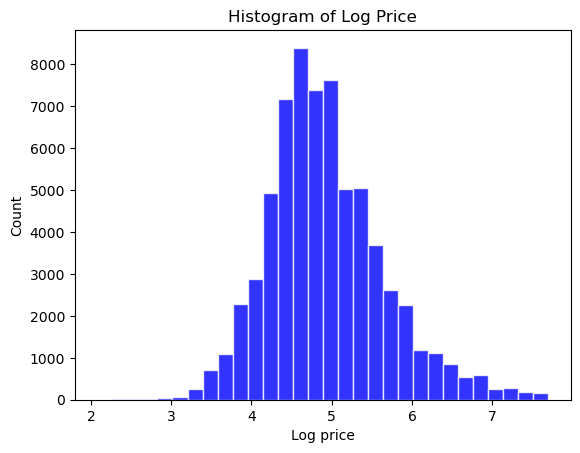

In [160]:
# calculate log price
data["ln_price"] = np.log(data.price)

# plot histogram
plt.hist(data['ln_price'], bins=30, color='blue', edgecolor='white', alpha=0.8)
plt.xlabel('Log price')
plt.ylabel('Count')
plt.title('Histogram of Log Price')
plt.show()

In [161]:
data.room_type.value_counts()

room_type
Entire home/apt    58433
Private room        7141
Hotel room           721
Shared room          409
Name: count, dtype: int64

In [162]:
# data['room_type'] = data[(data['room_type'] == "Entire home/apt") or  (data['room_type'] == "Private room ")]
# data.room_type = ['entire' if x == "Entire home/apt" else "private" for x in data.room_type]
# data["room_type"] = data["room_type"].astype("category")

# data.room_type.value_counts()

In [163]:
smf.ols(formula="ln_price ~ room_type", data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     1239.
Date:                Mon, 04 Mar 2024   Prob (F-statistic):               0.00
Time:                        16:34:07   Log-Likelihood:                -71582.
No. Observations:               66704   AIC:                         1.432e+05
Df Residuals:                   66700   BIC:                         1.432e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     4.9812      0.003   1701.484      0.000       4.975       4.987
room_type[T.Hotel room]       0.4994      0.027     18.832      0.000       0.447       0.551
room_type[T.Private room]    -0.4408      0.009    -49.685      0.000      -0.458      -0.423
room_type[T.Shared room]     -1.0478      0.035    -29.838      0.000      -1.117      -0.979
==============================================================================
Omnibus:                     7067.772   Durbin-Watson:                   1.824
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10494.650
Skew:                           0.803   Prob(JB):                         0.00
Kurtosis:                       4.093   Cond. No.                         12.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [164]:
data.beds.value_counts()

beds
1.0     35165
2.0     19656
3.0      6764
4.0      2818
5.0      1005
6.0       391
7.0       132
8.0        80
9.0        29
11.0        8
10.0        8
12.0        7
13.0        4
18.0        2
15.0        2
79.0        1
77.0        1
85.0        1
90.0        1
83.0        1
17.0        1
Name: count, dtype: int64

In [165]:
data.loc[data['beds']>10,'beds'] = 10 # winsorize extreme value
data.beds.describe()

count    66077.000000
mean         1.749580
std          1.060602
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         10.000000
Name: beds, dtype: float64

In [166]:
smf.ols(formula="ln_price ~ beds", data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                 1.818e+04
Date:                Mon, 04 Mar 2024   Prob (F-statistic):               0.00
Time:                        16:34:07   Log-Likelihood:                -64510.
No. Observations:               66077   AIC:                         1.290e+05
Df Residuals:                   66075   BIC:                         1.290e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.3780      0.005    908.210      0.000       4.369       4.387
beds           0.3177      0.002    134.832      0.000       0.313       0.322
==============================================================================
Omnibus:                     5389.353   Durbin-Watson:                   1.800
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10572.823
Skew:                           0.560   Prob(JB):                         0.00
Kurtosis:                       4.608   Cond. No.                         4.68
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [167]:
data.bathrooms_text.value_counts()

bathrooms_text
1 bath               48887
1.5 baths             4815
2 baths               4268
1 private bath        2913
1 shared bath         2838
2.5 baths             1031
3 baths                639
1.5 shared baths       362
Half-bath              244
3.5 baths              169
4 baths                106
0 baths                 99
2 shared baths          59
4.5 baths               42
Shared half-bath        36
0 shared baths          33
5 baths                 21
Private half-bath       20
2.5 shared baths        11
6 baths                 11
5.5 baths                6
3 shared baths           6
7 baths                  4
48 baths                 4
6.5 baths                3
49 baths                 2
7.5 baths                2
3.5 shared baths         2
6 shared baths           1
47 baths                 1
4 shared baths           1
10 baths                 1
5.5 shared baths         1
8.5 baths                1
Name: count, dtype: int64

In [168]:
# transfer into numerical
tmp = data.bathrooms_text
tmp = tmp.replace({'Shared half-bath':0.5, 'Half-bath':0.5})
tmp = tmp.str.extractall(r'(\d+(?:\.\d+)?)')
tmp.columns =['n_bath']
tmp = tmp.reset_index(level=1).drop('match',axis=1)
data = data.merge(tmp,left_index=True,right_index=True,how = 'outer', validate='one_to_one')
data.n_bath = data.n_bath.astype('float')
data.n_bath.value_counts().sort_index()

n_bath
0.0       132
1.0     54638
1.5      5177
2.0      4327
2.5      1042
3.0       645
3.5       171
4.0       107
4.5        42
5.0        21
5.5         7
6.0        12
6.5         3
7.0         4
7.5         2
8.5         1
10.0        1
47.0        1
48.0        4
49.0        2
Name: count, dtype: int64

In [169]:
data.loc[data['n_bath']>10,'n_bath'] = 10 # winsorize extreme value
data.n_bath.describe()

count    66339.000000
mean         1.163411
std          0.446981
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         10.000000
Name: n_bath, dtype: float64

In [170]:
smf.ols(formula="ln_price ~ n_bath", data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                 1.447e+04
Date:                Mon, 04 Mar 2024   Prob (F-statistic):               0.00
Time:                        16:34:08   Log-Likelihood:                -66262.
No. Observations:               66339   AIC:                         1.325e+05
Df Residuals:                   66337   BIC:                         1.325e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1364      0.007    581.573      0.000       4.122       4.150
n_bath         0.6864      0.006    120.275      0.000       0.675       0.698
==============================================================================
Omnibus:                     5036.568   Durbin-Watson:                   1.786
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14698.716
Skew:                           0.408   Prob(JB):                         0.00
Kurtosis:                       5.157   Cond. No.                         5.53
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [171]:
data.review_scores_rating.describe()

count    52469.000000
mean         4.695010
std          0.426015
min          0.000000
25%          4.580000
50%          4.820000
75%          5.000000
max          5.000000
Name: review_scores_rating, dtype: float64

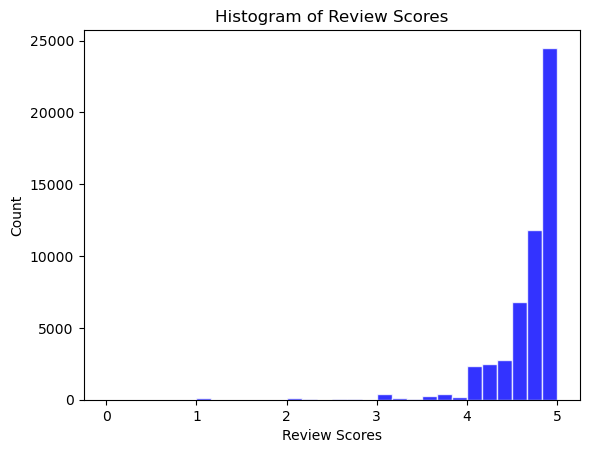

In [172]:
# plot histogram
plt.hist(data['review_scores_rating'], bins=30, color='blue', edgecolor='white', alpha=0.8)
plt.xlabel('Review Scores')
plt.ylabel('Count')
plt.title('Histogram of Review Scores')
plt.show()

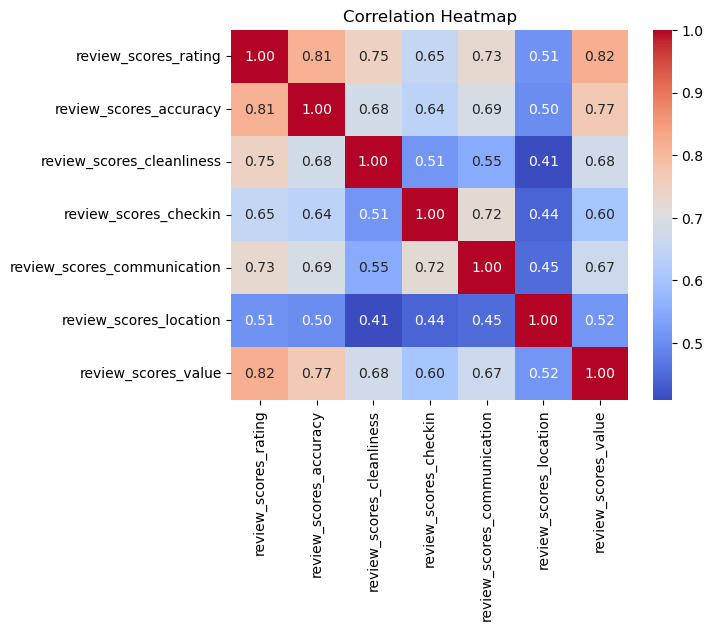

In [173]:
rscores = data.loc[:,[x for x in data.columns if 'review_scores' in x]]
correlation_matrix = rscores.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [174]:
smf.ols(formula="ln_price ~ review_scores_rating", data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     607.3
Date:                Mon, 04 Mar 2024   Prob (F-statistic):          2.45e-133
Time:                        16:34:09   Log-Likelihood:                -52320.
No. Observations:               52469   AIC:                         1.046e+05
Df Residuals:                   52467   BIC:                         1.047e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                4.1044      0.032    129.532      0.000       4.042       4.167
review_scores_rating     0.1656      0.007     24.644      0.000       0.152       0.179
==============================================================================
Omnibus:                     3279.211   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4615.266
Skew:                           0.553   Prob(JB):                         0.00
Kurtosis:                       3.941   Cond. No.                         54.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [175]:
smf.ols(formula="ln_price ~ review_scores_location", data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1022.
Date:                Mon, 04 Mar 2024   Prob (F-statistic):          4.57e-222
Time:                        16:34:09   Log-Likelihood:                -52091.
No. Observations:               52454   AIC:                         1.042e+05
Df Residuals:                   52452   BIC:                         1.042e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  3.5400      0.042     84.117      0.000       3.458       3.623
review_scores_location     0.2794      0.009     31.965      0.000       0.262       0.297
==============================================================================
Omnibus:                     3312.147   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4716.866
Skew:                           0.553   Prob(JB):                         0.00
Kurtosis:                       3.966   Cond. No.                         74.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [176]:
data.minimum_nights.describe()

count    66704.000000
mean        42.671669
std        108.695509
min          1.000000
25%          2.000000
50%          3.000000
75%          6.000000
max       1000.000000
Name: minimum_nights, dtype: float64

In [177]:
minimum_nightsH = data.minimum_nights.mean()+3*data.minimum_nights.std()
minimum_nightsL = data.minimum_nights.mean()-3*data.minimum_nights.std()
data = data.loc[(data.minimum_nights < minimum_nightsH) & (data.minimum_nights > minimum_nightsL) ]
data.minimum_nights.describe()

count    66679.000000
mean        42.453771
std        108.025480
min          1.000000
25%          2.000000
50%          3.000000
75%          6.000000
max        366.000000
Name: minimum_nights, dtype: float64

In [178]:
smf.ols(formula="ln_price ~ minimum_nights", data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     3996.
Date:                Mon, 04 Mar 2024   Prob (F-statistic):               0.00
Time:                        16:34:09   Log-Likelihood:                -71424.
No. Observations:               66679   AIC:                         1.429e+05
Df Residuals:                   66677   BIC:                         1.429e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          5.0010      0.003   1701.755      0.000       4.995       5.007
minimum_nights    -0.0016   2.53e-05    -63.215      0.000      -0.002      -0.002
==============================================================================
Omnibus:                     5863.874   Durbin-Watson:                   1.845
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8739.776
Skew:                           0.691   Prob(JB):                         0.00
Kurtosis:                       4.113   Cond. No.                         125.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [179]:
data.host_is_superhost.value_counts()

host_is_superhost
f    55099
t    11495
Name: count, dtype: int64

In [180]:
smf.ols(formula="ln_price ~ host_is_superhost", data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     536.0
Date:                Mon, 04 Mar 2024   Prob (F-statistic):          4.17e-118
Time:                        16:34:09   Log-Likelihood:                -73008.
No. Observations:               66594   AIC:                         1.460e+05
Df Residuals:                   66592   BIC:                         1.460e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  4.9037      0.003   1589.280      0.000       4.898       4.910
host_is_superhost[T.t]     0.1719      0.007     23.151      0.000       0.157       0.186
==============================================================================
Omnibus:                     5834.849   Durbin-Watson:                   1.779
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8334.338
Skew:                           0.707   Prob(JB):                         0.00
Kurtosis:                       4.001   Cond. No.                         2.74
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [181]:
data.accommodates.describe()

count    66679.000000
mean         3.137405
std          1.630047
min          1.000000
25%          2.000000
50%          2.000000
75%          4.000000
max         16.000000
Name: accommodates, dtype: float64

In [182]:
smf.ols(formula="ln_price ~ accommodates", data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                 2.575e+04
Date:                Mon, 04 Mar 2024   Prob (F-statistic):               0.00
Time:                        16:34:10   Log-Likelihood:                -62478.
No. Observations:               66679   AIC:                         1.250e+05
Df Residuals:                   66677   BIC:                         1.250e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        4.1944      0.005    808.534      0.000       4.184       4.205
accommodates     0.2354      0.001    160.459      0.000       0.233       0.238
==============================================================================
Omnibus:                     6598.438   Durbin-Watson:                   1.749
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12302.307
Skew:                           0.674   Prob(JB):                         0.00
Kurtosis:                       4.617   Cond. No.                         8.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [183]:
data['ln_accommodates'] = np.log(data['accommodates'])
smf.ols(formula="ln_price ~ ln_accommodates+accommodates", data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                 1.351e+04
Date:                Mon, 04 Mar 2024   Prob (F-statistic):               0.00
Time:                        16:34:10   Log-Likelihood:                -62023.
No. Observations:               66679   AIC:                         1.241e+05
Df Residuals:                   66676   BIC:                         1.241e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           4.1128      0.006    707.467      0.000       4.101       4.124
ln_accommodates     0.4974      0.016     30.294      0.000       0.465       0.530
accommodates        0.0984      0.005     20.712      0.000       0.089       0.108
==============================================================================
Omnibus:                     6831.164   Durbin-Watson:                   1.752
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12501.330
Skew:                           0.699   Prob(JB):                         0.00
Kurtosis:                       4.595   Cond. No.                         27.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [184]:
data.number_of_reviews.describe()

count    66679.000000
mean        24.812055
std         57.090194
min          0.000000
25%          1.000000
50%          7.000000
75%         24.000000
max       2636.000000
Name: number_of_reviews, dtype: float64

In [185]:
smf.ols(formula="ln_price ~ number_of_reviews", data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     8.695
Date:                Mon, 04 Mar 2024   Prob (F-statistic):            0.00319
Time:                        16:34:10   Log-Likelihood:                -73360.
No. Observations:               66679   AIC:                         1.467e+05
Df Residuals:                   66677   BIC:                         1.467e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.9367      0.003   1607.974      0.000       4.931       4.943
number_of_reviews    -0.0001   4.93e-05     -2.949      0.003      -0.000   -4.88e-05
==============================================================================
Omnibus:                     5399.619   Durbin-Watson:                   1.782
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7515.442
Skew:                           0.677   Prob(JB):                         0.00
Kurtosis:                       3.933   Cond. No.                         67.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [186]:
data['ln_number_of_reviews'] = np.log(data['number_of_reviews']+1e-10 )  # +1e-10 to avoid -inf
data.ln_number_of_reviews.describe()

count    6.667900e+04
mean    -3.027655e+00
std      1.053671e+01
min     -2.302585e+01
25%      1.000000e-10
50%      1.945910e+00
75%      3.178054e+00
max      7.877018e+00
Name: ln_number_of_reviews, dtype: float64

In [187]:
smf.ols(formula="ln_price ~ ln_number_of_reviews+number_of_reviews", data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     564.6
Date:                Mon, 04 Mar 2024   Prob (F-statistic):          7.23e-244
Time:                        16:34:10   Log-Likelihood:                -72805.
No. Observations:               66679   AIC:                         1.456e+05
Df Residuals:                   66676   BIC:                         1.456e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                4.8955      0.003   1490.656      0.000       4.889       4.902
ln_number_of_reviews    -0.0093      0.000    -33.471      0.000      -0.010      -0.009
number_of_reviews        0.0004   5.14e-05      7.373      0.000       0.000       0.000
==============================================================================
Omnibus:                     4100.515   Durbin-Watson:                   1.794
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5382.327
Skew:                           0.575   Prob(JB):                         0.00
Kurtosis:                       3.783   Cond. No.                         73.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## model selection

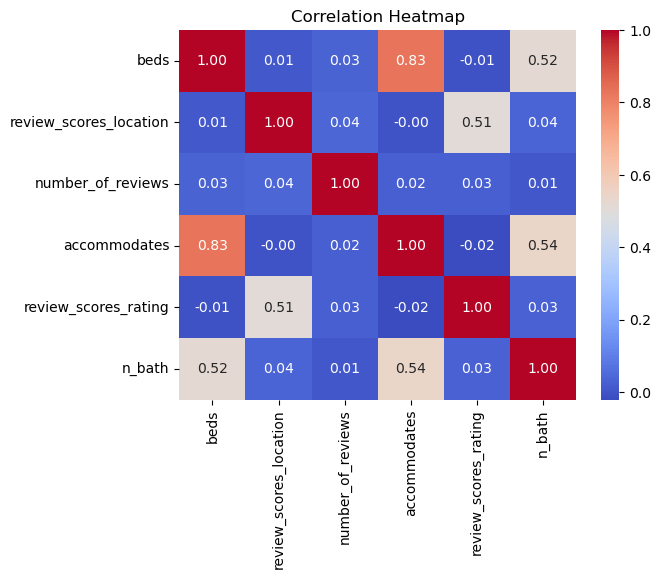

In [205]:
factors = data.loc[:,['beds','review_scores_location','number_of_reviews','accommodates','review_scores_rating','n_bath']]
correlation_matrix = factors.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


In [189]:
smf.ols(formula="ln_price ~ room_type+beds+room_type+number_of_reviews+accommodates+n_bath+host_is_superhost", data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     4169.
Date:                Mon, 04 Mar 2024   Prob (F-statistic):               0.00
Time:                        16:34:11   Log-Likelihood:                -58388.
No. Observations:               65617   AIC:                         1.168e+05
Df Residuals:                   65608   BIC:                         1.169e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     4.0077      0.007    584.361      0.000       3.994       4.021
room_type[T.Hotel room]       0.6556      0.025     26.060      0.000       0.606       0.705
room_type[T.Private room]    -0.2204      0.008    -28.229      0.000      -0.236      -0.205
room_type[T.Shared room]     -0.7945      0.030    -26.486      0.000      -0.853      -0.736
host_is_superhost[T.t]        0.1773      0.006     28.318      0.000       0.165       0.190
beds                          0.0400      0.004     10.044      0.000       0.032       0.048
number_of_reviews            -0.0005   4.25e-05    -12.937      0.000      -0.001      -0.000
accommodates                  0.1566      0.003     58.323      0.000       0.151       0.162
n_bath                        0.3177      0.006     51.178      0.000       0.306       0.330
==============================================================================
Omnibus:                     8155.346   Durbin-Watson:                   1.774
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21131.858
Skew:                           0.706   Prob(JB):                         0.00
Kurtosis:                       5.394   Cond. No.                         800.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [190]:
m1 = smf.ols(formula="ln_price ~ room_type+beds+room_type+number_of_reviews+accommodates+n_bath+host_is_superhost+neighbourhood_cleansed", data=data).fit()
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     1560.
Date:                Mon, 04 Mar 2024   Prob (F-statistic):               0.00
Time:                        16:34:11   Log-Likelihood:                -55596.
No. Observations:               65617   AIC:                         1.112e+05
Df Residuals:                   65589   BIC:                         1.115e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                       4.0458      0.011    384.846      0.000       4.025       4.066
room_type[T.Hotel room]                         0.5770      0.024     23.864      0.000       0.530       0.624
room_type[T.Private room]                      -0.2014      0.008    -26.801      0.000      -0.216      -0.187
room_type[T.Shared room]                       -0.7260      0.029    -25.179      0.000      -0.783      -0.670
host_is_superhost[T.t]                          0.1620      0.006     26.964      0.000       0.150       0.174
neighbourhood_cleansed[T.Bourse]                0.1310      0.015      9.022      0.000       0.103       0.160
neighbourhood_cleansed[T.Buttes-Chaumont]      -0.2436      0.012    -19.499      0.000      -0.268      -0.219
neighbourhood_cleansed[T.Buttes-Montmartre]    -0.1097      0.011    -10.168      0.000      -0.131      -0.089
neighbourhood_cleansed[T.Entrepôt]             -0.0170      0.012     -1.433      0.152      -0.040       0.006
neighbourhood_cleansed[T.Gobelins]             -0.1751      0.015    -11.687      0.000      -0.205      -0.146
neighbourhood_cleansed[T.Hôtel-de-Ville]        0.2524      0.015     17.004      0.000       0.223       0.282
neighbourhood_cleansed[T.Louvre]                0.3590      0.017     21.374      0.000       0.326       0.392
neighbourhood_cleansed[T.Luxembourg]            0.2757      0.016     17.704      0.000       0.245       0.306
neighbourhood_cleansed[T.Ménilmontant]         -0.2525      0.013    -19.961      0.000      -0.277      -0.228
neighbourhood_cleansed[T.Observatoire]         -0.0844      0.014     -5.897      0.000      -0.112      -0.056
neighbourhood_cleansed[T.Opéra]                 0.1463      0.013     11.188      0.000       0.121       0.172
neighbourhood_cleansed[T.Palais-Bourbon]        0.3238      0.016     20.488      0.000       0.293       0.355
neighbourhood_cleansed[T.Panthéon]              0.1293      0.015      8.581      0.000       0.100       0.159
neighbourhood_cleansed[T.Passy]                 0.2189      0.012     17.636      0.000       0.195       0.243
neighbourhood_cleansed[T.Popincourt]           -0.0603      0.011     -5.348      0.000      -0.082      -0.038
neighbourhood_cleansed[T.Reuilly]              -0.1266      0.014     -9.053      0.000      -0.154      -0.099
neighbourhood_cleansed[T.Temple]                0.1651      0.014     12.215      0.000       0.139       0.192
neighbourhood_cleansed[T.Vaugirard]             0.0293      0.012      2.504      0.012       0.006       0.052
neighbourhood_cleansed[T.Élysée]                0.2736      0.015     18.166      0.000       0.244       0.303
beds                                            0.0438     

# BP TEST: Heteroskedasticity

In [191]:
# Perform the Breusch-Pagan test
def bpTest(model):
    breusch_pagan_test = sm.stats.diagnostic.het_breuschpagan(model.resid, model.model.exog)
    print("Breusch-Pagan Test:")
    print("Lagrange multiplier statistic:", breusch_pagan_test[0])
    print("p-value:", breusch_pagan_test[1])
    print("f-value:", breusch_pagan_test[2])
    print("f p-value:", breusch_pagan_test[3])
bpTest(m1)

Breusch-Pagan Test:
Lagrange multiplier statistic: 2236.310635764362
p-value: 0.0
f-value: 85.71215533758667
f p-value: 0.0


In [239]:
m1_hc = smf.ols(formula="ln_price ~ room_type+beds+number_of_reviews+accommodates+n_bath+host_is_superhost+neighbourhood_cleansed+minimum_nights+review_scores_rating+review_scores_location", data=datacleaned).fit(cov_type='HC3')
m1_hc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     1245.
Date:                Mon, 04 Mar 2024   Prob (F-statistic):               0.00
Time:                        17:04:18   Log-Likelihood:                -34792.
No. Observations:               51688   AIC:                         6.965e+04
Df Residuals:                   51657   BIC:                         6.992e+04
Df Model:                          30                                         
Covariance Type:                  HC3                                         
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                       3.3357      0.041     81.037      0.000       3.255       3.416
room_type[T.Hotel room]                         0.4998      0.020     25.192      0.000       0.461       0.539
room_type[T.Private room]                      -0.2895      0.009    -33.243      0.000      -0.307      -0.272
room_type[T.Shared room]                       -0.7507      0.040    -18.894      0.000      -0.829      -0.673
host_is_superhost[T.t]                          0.1193      0.005     22.658      0.000       0.109       0.130
neighbourhood_cleansed[T.Bourse]                0.1689      0.014     12.338      0.000       0.142       0.196
neighbourhood_cleansed[T.Buttes-Chaumont]      -0.2244      0.012    -19.079      0.000      -0.247      -0.201
neighbourhood_cleansed[T.Buttes-Montmartre]    -0.0780      0.011     -7.392      0.000      -0.099      -0.057
neighbourhood_cleansed[T.Entrepôt]              0.0091      0.011      0.800      0.424      -0.013       0.031
neighbourhood_cleansed[T.Gobelins]             -0.1525      0.014    -10.642      0.000      -0.181      -0.124
neighbourhood_cleansed[T.Hôtel-de-Ville]        0.2816      0.015     19.402      0.000       0.253       0.310
neighbourhood_cleansed[T.Louvre]                0.3762      0.016     23.263      0.000       0.345       0.408
neighbourhood_cleansed[T.Luxembourg]            0.2993      0.017     17.288      0.000       0.265       0.333
neighbourhood_cleansed[T.Ménilmontant]         -0.2314      0.012    -19.994      0.000      -0.254      -0.209
neighbourhood_cleansed[T.Observatoire]         -0.0629      0.013     -4.681      0.000      -0.089      -0.037
neighbourhood_cleansed[T.Opéra]                 0.1446      0.013     11.400      0.000       0.120       0.169
neighbourhood_cleansed[T.Palais-Bourbon]        0.3506      0.017     20.800      0.000       0.318       0.384
neighbourhood_cleansed[T.Panthéon]              0.1700      0.014     11.805      0.000       0.142       0.198
neighbourhood_cleansed[T.Passy]                 0.2026      0.013     15.173      0.000       0.176       0.229
neighbourhood_cleansed[T.Popincourt]           -0.0335      0.011     -3.125      0.002      -0.055      -0.012
neighbourhood_cleansed[T.Reuilly]              -0.1202      0.013     -9.163      0.000      -0.146      -0.094
neighbourhood_cleansed[T.Temple]                0.2110      0.013     16.523      0.000       0.186       0.236
neighbourhood_cleansed[T.Vaugirard]             0.0593      0.012      5.067      0.000       0.036       0.082
neighbourhood_cleansed[T.Élysée]                0.2867      0.016     17.591      0.000       0.255       0.319
beds                                            0.0398     

In [194]:
# data.loc[data['beds']<=2,'beds2'] = 'small'
# data.loc[(data['beds']>2) & (data['beds']<7),'beds2'] = 'medium'
# data.loc[data['beds']>=7,'beds2'] = 'big'
# data.beds2.value_counts()

# VIF TEST

In [235]:

# Define your formula
formula="ln_price ~ beds+room_type+number_of_reviews+accommodates+n_bath+host_is_superhost+neighbourhood_cleansed+minimum_nights+review_scores_rating+review_scores_location"
# Create design matrices
y, X = dmatrices(formula, data=data, return_type='dataframe')

# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)


                                       Variable         VIF
0                                     Intercept  271.330490
1                       room_type[T.Hotel room]    1.017075
2                     room_type[T.Private room]    1.095457
3                      room_type[T.Shared room]    1.017257
4                        host_is_superhost[T.t]    1.110297
5              neighbourhood_cleansed[T.Bourse]    1.564864
6     neighbourhood_cleansed[T.Buttes-Chaumont]    1.844261
7   neighbourhood_cleansed[T.Buttes-Montmartre]    2.533670
8            neighbourhood_cleansed[T.Entrepôt]    2.033948
9            neighbourhood_cleansed[T.Gobelins]    1.480629
10     neighbourhood_cleansed[T.Hôtel-de-Ville]    1.518801
11             neighbourhood_cleansed[T.Louvre]    1.371945
12         neighbourhood_cleansed[T.Luxembourg]    1.429957
13       neighbourhood_cleansed[T.Ménilmontant]    1.815754
14       neighbourhood_cleansed[T.Observatoire]    1.532285
15              neighbourhood_cleansed[T

In [236]:
from statsmodels.stats.outliers_influence import OLSInfluence
OLSInfluence(m1_hc).dfbetas

KeyboardInterrupt: 

In [251]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Get the predicted values and squared predicted values
predicted_values = m1_hc.fittedvalues
predicted_values_squared = predicted_values ** 2

# Fit the auxiliary regression
reset_auxiliary_model = sm.OLS(datacleaned["ln_price"].values, sm.add_constant(pd.concat([predicted_values, predicted_values_squared], axis=1))).fit()

# Perform RESET test
reset_test_results = reset_auxiliary_model.f_test("(x2 = 0)").pvalue
print("RESET test p-value:", reset_test_results)


ValueError: endog and exog matrices are different sizes